In [ ]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Chemoinformatics
!pip install rdkit
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import QED, Descriptors, Draw, rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.SimDivFilters import rdSimDivPickers
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Machine learning
from sklearn.model_selection import train_test_split
# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

print(rdkit.__version__)

2024.09.6


In [ ]:
data = pd.read_csv("data_train.csv",index_col=0).reset_index(drop=True)
data.head()

,smiles,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,CC=C(CCC(C)C1CCC2C3=CCC4C(C)C(O)CCC4(C)C3CCC21...,0,0,0,0,-1,-1,0,0,0,0,0
1,O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12,0,0,0,0,1,0,0,0,0,0,-1
2,CC(C)(C)OCC1CO1,0,0,0,0,-1,-1,0,0,0,0,0
3,CN(C(=O)CCCOc1ccc2[nH]c(=O)ccc2c1)C1CCCCC1,0,0,0,0,-1,-1,0,0,0,0,-1
4,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,0,0,0,0,0,0,-1,0,0,0,-1


Convert SMILES to rdkit mols: 100%|██████████| 12000/12000 [00:02<00:00, 5063.24it/s]


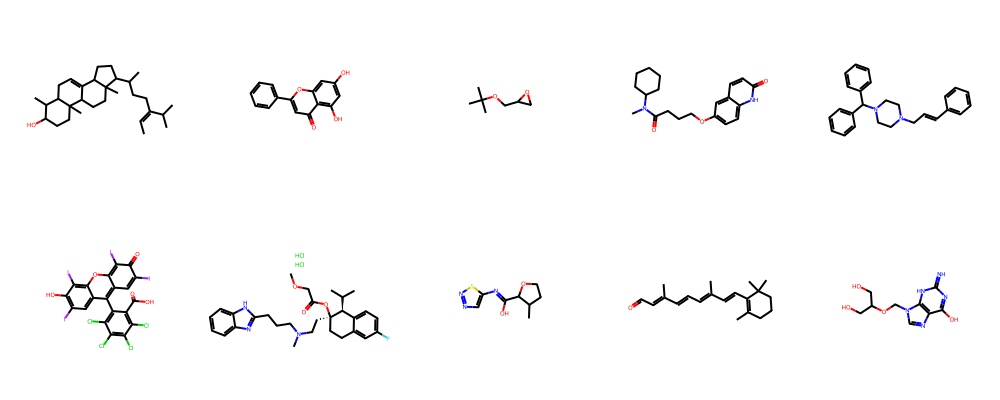

In [ ]:
data['mol'] = [Chem.MolFromSmiles(smi) for smi in tqdm(data['smiles'], desc='Convert SMILES to rdkit mols')]
Draw.MolsToGridImage(data['mol'][:10], molsPerRow=5)

In [ ]:
mfpgen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
fps = np.array([mfpgen.GetFingerprintAsNumPy(mol) for mol in tqdm(data.mol, desc='Compute Morgan fingerprints')])
fps

Compute Morgan fingerprints: 100%|██████████| 12000/12000 [00:00<00:00, 13243.89it/s]


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [ ]:
data.replace(0, np.nan, inplace=True)
#data.replace(-1, 0, inplace=True)

data.head()

,smiles,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11,mol
0,CC=C(CCC(C)C1CCC2C3=CCC4C(C)C(O)CCC4(C)C3CCC21...,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ebfdab126c0>
1,O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-1.0,<rdkit.Chem.rdchem.Mol object at 0x7ebfdab12500>
2,CC(C)(C)OCC1CO1,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ebfdab12260>
3,CN(C(=O)CCCOc1ccc2[nH]c(=O)ccc2c1)C1CCCCC1,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN,-1.0,<rdkit.Chem.rdchem.Mol object at 0x7ebfdab122d0>
4,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,<rdkit.Chem.rdchem.Mol object at 0x7ebfdab12340>


In [ ]:
#y = data[data.columns[1:-1]]
#y.head()
y = data[data.columns[1:-1]].values
y

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, -1.],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, -1.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, -1.]])

In [ ]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fps, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9600, 1024), (2400, 1024), (9600, 11), (2400, 11))

In [ ]:
def train_rf(X_train, y_train, X_test):
    """
    Train a random forest model for each task on the supplied training set and return predictions for the test set
    """
    seed = 1234
    n_tasks = y_train.shape[1]
    y_hats_proba = np.empty((X_test.shape[0], n_tasks))
    y_hats_class = np.empty_like(y_hats_proba)

    # Train RF per task
    for j in tqdm(range(n_tasks), desc='Train RF per task'):
        rf_model = RandomForestClassifier(n_estimators=500, max_depth = 30, min_samples_split=2, min_samples_leaf=1, random_state=seed, max_features='log2')
        # Mask out unknown samples and NaN values
        idx = (~np.isnan(y_train[:, j]))
        '''
        print(y_train[:, j])
        print(np.isnan(y_train[:, j]))
        print(idx)
        print(X_train[idx])
        print(y_train[idx, j])'''
        # Train model
        rf_model.fit(X_train[idx], y_train[idx, j])
        # Predict class probabilities (select only values for positiv class with index 1)
        y_hats_proba[:, j] = rf_model.predict_proba(X_test)[:, 1]
        # Predict class
        y_hats_class[:, j] = rf_model.predict(X_test)
    return y_hats_proba, y_hats_class

y_hats_proba, y_hats_class = train_rf(X_train, y_train, X_test)

Train RF per task: 100%|██████████| 11/11 [00:29<00:00,  2.67s/it]


We can look at the predicted probabilities and classes. Since the model doesn't know which values of the test set are actually measured and which are missing we get a prediction for each sample.

In [ ]:
# probabilistic predictions for test set, 12 tasks
pd.DataFrame(y_hats_proba)

,0,1,2,3,4,5,6,7,8,9,10
0,0.022805,0.453164,0.830120,0.594497,0.522989,0.063548,0.123278,0.219894,0.272376,0.042530,0.006006
1,0.046462,0.567818,0.917533,0.784265,0.247290,0.030017,0.023114,0.094812,0.212437,0.108649,0.004000
2,0.006457,0.337380,0.906481,0.588857,0.348225,0.007759,0.012521,0.083931,0.164855,0.023738,0.004384
3,0.126333,0.585480,0.725686,0.807050,0.257055,0.170920,0.074524,0.347588,0.407251,0.124581,0.006231
4,0.134299,0.591381,0.731198,0.741214,0.251940,0.109484,0.059076,0.388650,0.269625,0.132985,0.028000
...,...,...,...,...,...,...,...,...,...,...,...
2395,0.075851,0.456963,0.740227,0.662963,0.171202,0.078612,0.032461,0.252451,0.218230,0.051244,0.010675
2396,0.035913,0.461927,0.886830,0.661682,0.121340,0.034675,0.055200,0.125571,0.131919,0.044363,0.000051
2397,0.044617,0.348526,0.714473,0.630324,0.148119,0.027487,0.054282,0.155977,0.279734,0.065847,0.002010
2398,0.061318,0.584028,0.768421,0.716924,0.215270,0.093387,0.023863,0.200020,0.378796,0.070068,0.004050


In [ ]:
# binary predictions for test set, 12 tasks
pd.DataFrame(y_hats_class)

,0,1,2,3,4,5,6,7,8,9,10
0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
2395,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2396,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2397,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2398,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap for visualization
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred. Inactive", "Pred. Active"],
                yticklabels=["True Inactive", "True Active"])

    plt.title('Confusion Matrix')
    plt.show()

Let's look at the confusion matrix for the 1st task:

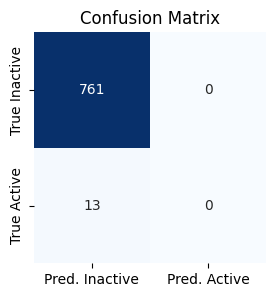

In [225]:
task = 10
idx = (~np.isnan(y_test[:, task]))
plot_confusion_matrix(y_test[idx,task], y_hats_class[idx,task])

In [ ]:
def classification_metrics(y_test, y_hats_class):

    # List of metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Balanced Accuracy', 'MCC']

    # Initialize a DataFrame
    result_df = pd.DataFrame(index=range(y_test.shape[1]), columns=metrics)

    # Calculate metrics for each target
    for j in range(y_test.shape[1]):
        y_true, y_pred = y_test[:, j], y_hats_class[:, j]
        idx = (~np.isnan(y_true))
        y_true, y_pred = y_true[idx], y_pred[idx]

        result_df.at[j, 'Accuracy'] = accuracy_score(y_true, y_pred)
        result_df.at[j, 'Precision'] = precision_score(y_true, y_pred)
        result_df.at[j, 'Recall'] = recall_score(y_true, y_pred)
        result_df.at[j, 'F1-Score'] = f1_score(y_true, y_pred)
        #result_df.at[j, 'Precision'] = precision_score(y_true, y_pred, average='micro')
        #result_df.at[j, 'Recall'] = recall_score(y_true, y_pred, average='micro')
        #result_df.at[j, 'F1-Score'] = f1_score(y_true, y_pred, average='micro')
        result_df.at[j, 'Balanced Accuracy'] = balanced_accuracy_score(y_true, y_pred)
        result_df.at[j, 'MCC'] = matthews_corrcoef(y_true, y_pred)

    return result_df

In [ ]:
df_stats = classification_metrics(y_test, y_hats_class)
df_stats

,Accuracy,Precision,Recall,F1-Score,Balanced Accuracy,MCC
0,0.902913,0.5,0.05,0.090909,0.522312,0.134743
1,0.551471,0.65,0.493671,0.561151,0.562625,0.124465
2,0.867384,0.866667,0.976526,0.918322,0.745839,0.602565
3,0.666667,0.677966,0.952381,0.792079,0.52381,0.092057
4,0.882517,0.8125,0.138298,0.236364,0.566733,0.304919
5,0.941589,1.0,0.056604,0.107143,0.528302,0.230837
6,0.923077,0.0,0.0,0.0,0.497409,-0.019377
7,0.875,0.666667,0.111111,0.190476,0.551318,0.236806
8,0.759162,0.766234,0.678161,0.719512,0.752542,0.512793
9,0.970297,1.0,0.4,0.571429,0.7,0.622799


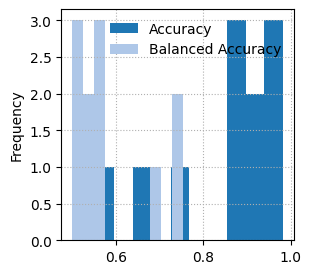

In [ ]:
df_stats['Accuracy'].plot(kind='hist',figsize=(3,3), legend=True)
df_stats['Balanced Accuracy'].plot(kind='hist',figsize=(3,3), legend=True)
plt.legend(frameon=False)
plt.grid(linestyle=':')

In [ ]:
from sklearn.metrics import roc_auc_score
sns.set_palette("tab20",plt.cm.tab20c.N )

def plot_roc_curves(target, prediction):
    fig, ax = plt.subplots(figsize=(5, 5))
    aucs = []
    auc_per_task = []
    for j in range(target.shape[1]):
        y_pred = prediction[:, j]
        y_true = target[:, j]
        # Mask out unknown samples and NaN values
        idx = (~np.isnan(y_true))
        # Calculate ROC and AUC
        fpr, tpr, thresholds = roc_curve(y_true[idx], y_pred[idx])
        roc_auc = auc(fpr, tpr)
        auc_per_task.append(roc_auc_score(y_true[idx], y_pred[idx]))
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, label=f'{j} (AUC = {roc_auc:.2f})')


    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve (Mean AUC = {np.mean(aucs):.3f})')
    #ax.set_title(f'ROC Curve (Mean AUC = {auc_per_task:.3f})')
    ax.legend(loc="lower right", edgecolor='w')
    ax.grid(linestyle=':')
    ax.plot([0,1], [0,1], 'k--')

    plt.show()

    avg_auc = np.mean(auc_per_task)
    print(avg_auc)

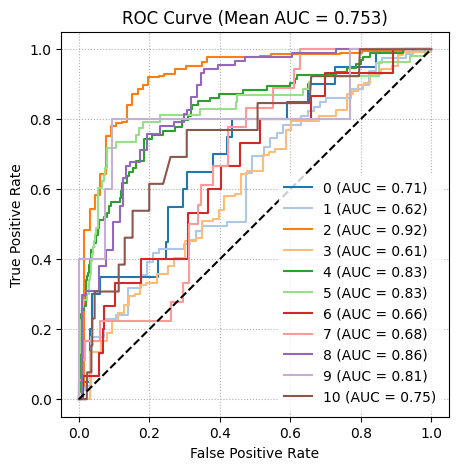

0.7530189666812542


In [ ]:
plot_roc_curves(y_test, y_hats_proba)

In [ ]:
pd.DataFrame(y_test).replace(np.nan, 0, inplace=True)
pd.DataFrame(y_test).to_csv("target.csv", index=True)
pd.DataFrame(y_hats_proba).to_csv("submission.csv", index=True)